# EDA of monster job postings

* generate distribution plot of soc major groups
* generate plot of word cloud (maybe)

In [16]:
# house keeping
import os
import json
import copy
import random

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid", font_scale=2)

from typing import Dict, Text, Any, Generator
import pickle

## skills-ml
from skills_ml.job_postings.raw.virginia import VirginiaTransformer
from skills_ml.job_postings.filtering import JobPostingFilterer

### plot soc major group distribution
from skills_ml.ontologies.onet import majorgroupname
from collections import Counter

In [3]:
# job posting json (with predicted soc code)

dirPname = '../output/'
fname = 'monster_soc_output'

In [6]:
# parse dataset into generator format
JobPostingType = Dict[Text, Any]
JobPostingGeneratorType = Generator[JobPostingType, None, None]
MetadataType = Dict[Text, Dict[Text, Any]]

class monsterSOCOutputParser(object):
    def __init__(self):
        fname = '../output/monster_soc_output.json'
        f = open(fname, 'r')
        self.lines = f.read().split('\n')
        self.transformer = VirginiaTransformer(partner_id = 'VA')
        
    def __iter__(self) -> JobPostingGeneratorType:
        for line in self.lines:
            if line:
                yield self.transformer._transform(json.loads(line))
    
    @property
    def metadata(self) -> MetadataType:
        return {'job postings': {
            'downloaded_from': 'jobs.monster.com',
            'month': '2020-08',
            'purpose': 'monster_analysis'
        }}
    
job_postings = monsterSOCOutputParser()

In [8]:
# filtering

def is_tech_jobs(job):
    if job['onet_soc_code'][:2] in ['15', '17', '19']:
        return True
    else:
        return False

tech_jobs = JobPostingFilterer(
    job_posting_generator=job_postings, 
    filter_funcs=[is_tech_jobs]
)

In [28]:
# major group distribution plotting function

def plot_major_group_distribution(job_postings):
    c = Counter()
    for job in job_postings:
        c.update([job['onet_soc_code'][:2]])
    s = pd.Series(c).sort_index()
    s.index = s.index.map(majorgroupname)
    ax = s.plot.bar(figsize=(20,10),rot=90)
    ax.set_xlabel('soc_major_group')
    ax.set_yscale("log")
    ax.set_ylabel('number of job posting')
#     ax.set_title(f"total number: {s.sum()}")
    return s

Computer and Mathematical             5781
Architecture and Engineering          2525
Life, Physical, and Social Science    7440
dtype: int64

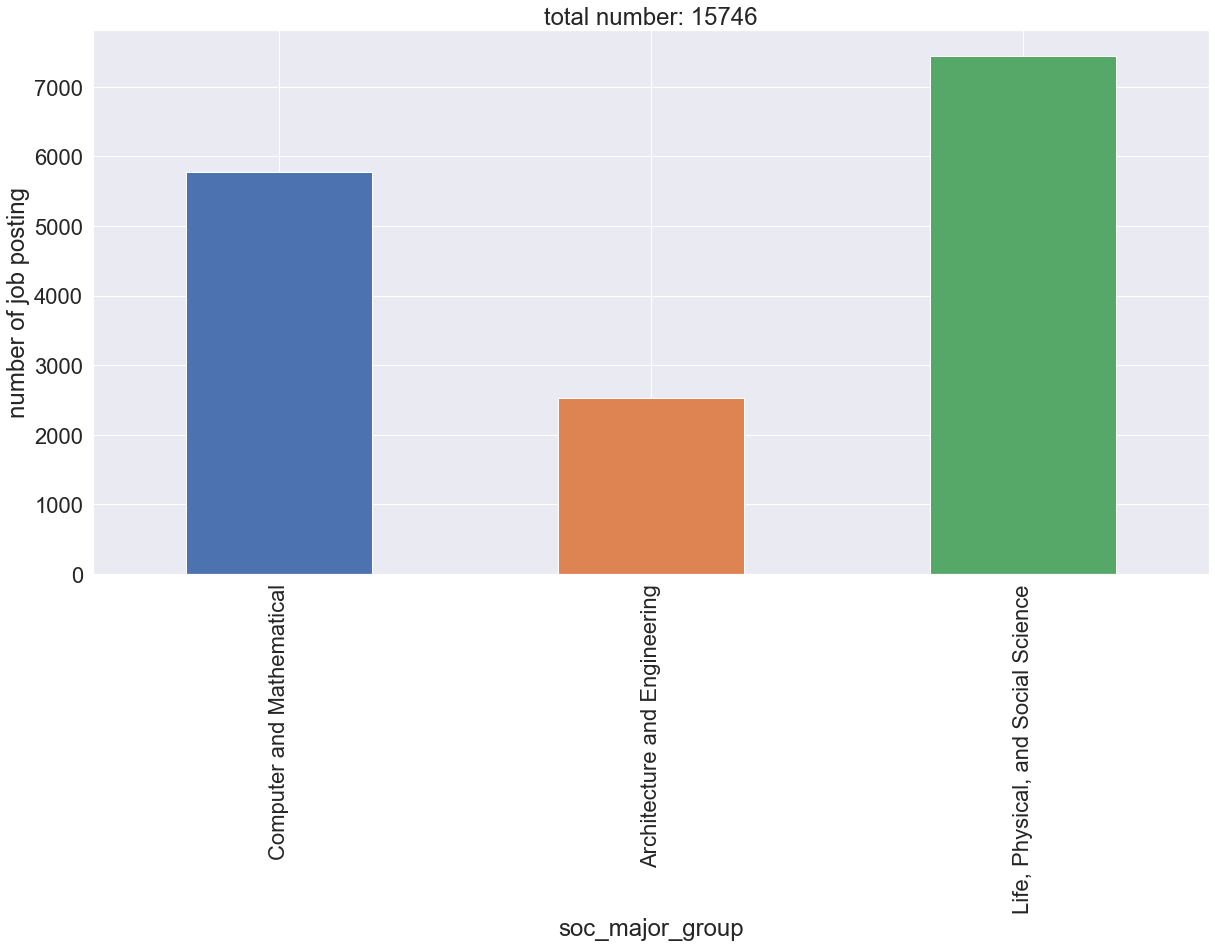

In [10]:
plot_major_group_distribution(tech_jobs)

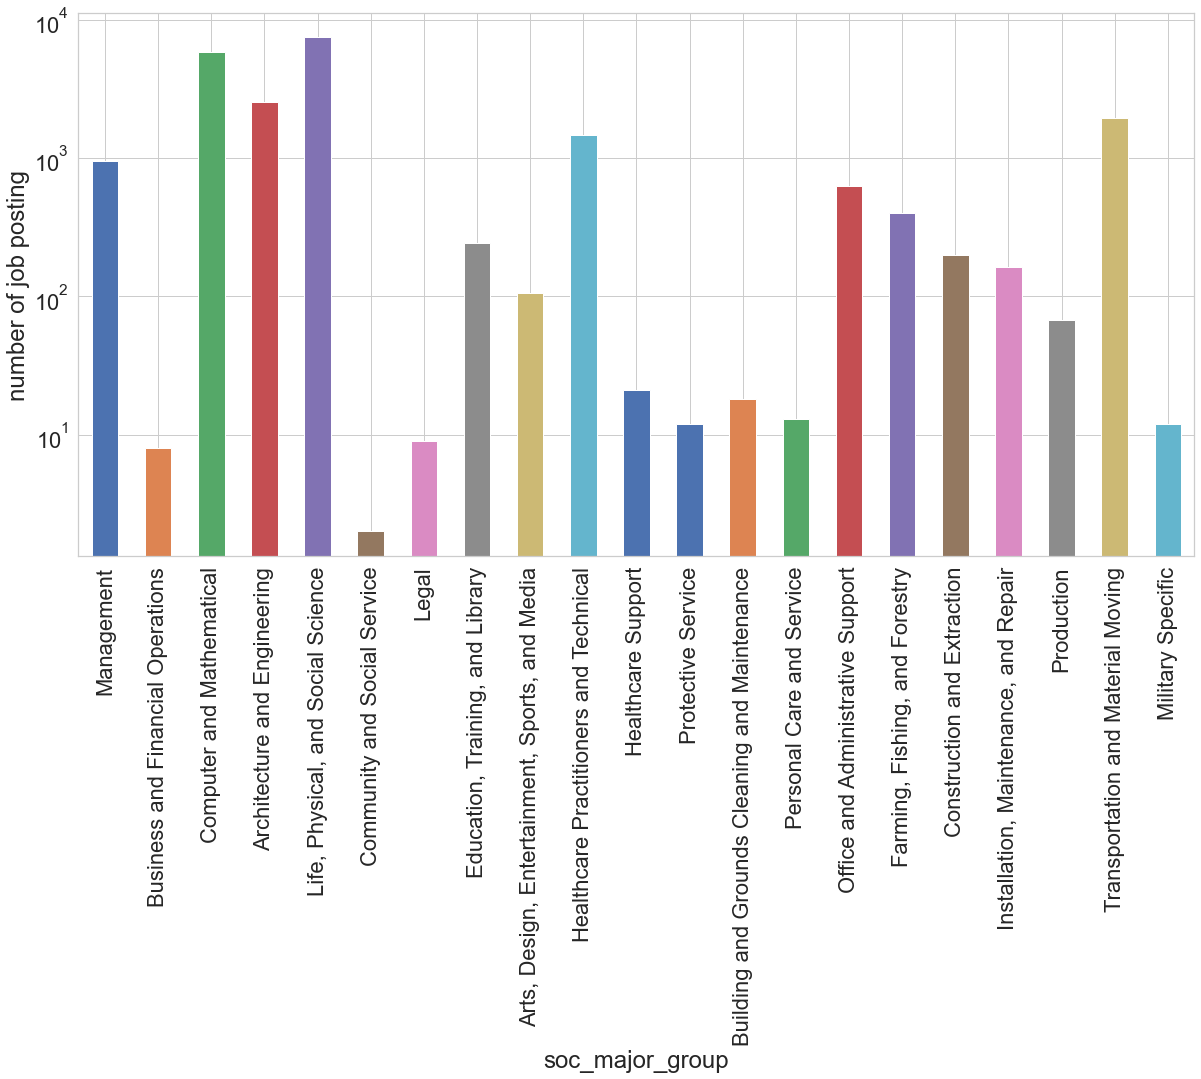

In [29]:
def filter_onet_soc_code(job):
    if job['onet_soc_code'] and job['onet_soc_code'][:2] != '99':
        return True
    else:
        return False

has_soc = lambda x: x['onet_soc_code']
not_unknown_soc = lambda x: x['onet_soc_code'][:2] != '99'

jobpostings_filtered = JobPostingFilterer(
    job_posting_generator=job_postings, 
    filter_funcs=[has_soc, not_unknown_soc]
)

plot_major_group_distribution(jobpostings_filtered)
plt.savefig('../output/soc_distribution.png')

## analysis

# Embedding Model

## Train

In [37]:
# embedding
from skills_ml.algorithms.embedding.models import Word2VecModel, FastTextModel
from skills_ml.job_postings.corpora import Word2VecGensimCorpusCreator, Doc2VecGensimCorpusCreator
from skills_ml.algorithms.preprocessing import IterablePipeline
from skills_ml.algorithms import nlp
from functools import partial
from skills_ml.algorithms.embedding.train import EmbeddingTrainer

In [39]:
## reads json data file

JobPostingType = Dict[Text, Any]
JobPostingGeneratorType = Generator[JobPostingType, None, None]
MetadataType = Dict[Text, Dict[Text, Any]]

class monsterParser(object):
    def __init__(self):
        fname = '../data/monster_220k.json'
        f = open(fname, 'r')
        self.lines = f.read().split('\n')
        self.transformer = VirginiaTransformer(partner_id = 'VA')
        
    def __iter__(self) -> JobPostingGeneratorType:
        for line in self.lines:
            if line:
                yield self.transformer._transform(json.loads(line))
    
    @property
    def metadata(self) -> MetadataType:
        return {'job postings': {
            'downloaded_from': 'jobs.monster.com',
            'month': '2020-08',
            'purpose': 'monster_analysis'
        }}

In [40]:
job_postings = monsterParser()

In [41]:
cbow = Word2VecModel(size=200, sg=0, window=7, iter=3, batch_words=1000)
skip_gram = Word2VecModel(size=200, sg=1, window=7, iter=3, batch_words=1000)
fasttext = FastTextModel(size=200, window=7, iter=3, batch_words=1000) 

w2v_corpus_generator = Word2VecGensimCorpusCreator(job_postings)

In [42]:
trainer = EmbeddingTrainer(cbow, skip_gram, fasttext, batch_size=100)
trainer.train(w2v_corpus_generator)

limit_output extension: Maximum message size of 10000 exceeded with 10080 characters

KeyboardInterrupt: 

In [43]:
for c, s in zip(cbow.wv.most_similar(['engineer']), skip_gram.wv.most_similar(['engineer'])):
    print(c, s)

('designer', 0.6822404861450195) ('routercim', 0.549312174320221)
('programmer', 0.6532644629478455) ('thermwood', 0.5398135781288147)
('technician', 0.6335660219192505) ('designer', 0.518282949924469)
('developer', 0.629605770111084) ('winpro', 0.5175251960754395)
('scientist', 0.6081100106239319) ('estimator', 0.5173708200454712)
('devops', 0.6034386157989502) ('chemist', 0.5036550164222717)
('sr', 0.6019145250320435) ('mep', 0.49818122386932373)
('specialist', 0.6001996994018555) ('bsme', 0.49723827838897705)
('nc', 0.5870262980461121) ('murata', 0.49615249037742615)
('architect', 0.5801641345024109) ('inventor', 0.49365490674972534)


## Evaluate embedding model

In [31]:
from skills_ml.ontologies.onet import Onet

onet = Onet()
onet.print_summary_stats()

Ontology summary statistics for onet
Num competencies: 32030
Num occupations: 1133
Num competency-occupation edges: 107305
Median occupations per competency: 1
Median competencies per occupation: 89
Mean occupations per competency: 3.350245090386837
Mean competencies per occupation: 94.70873786407768


In [44]:
major_group_occupation_des_clustering = onet.major_group_occupation_description_clustering

In [45]:
from skills_ml.evaluation.embedding_metrics import metrics_for_embedding, CategorizationMetric, IntraClusterCohesion, RecallTopN, PrecisionTopN
from skills_ml.algorithms.preprocessing import ProcessingPipeline

def vectorization(embedding):
    p = ProcessingPipeline(
        nlp.normalize,
        nlp.clean_str,
        nlp.word_tokenize,
        partial(nlp.vectorize, embedding_model=embedding)
    )
    return p

categorization_metric = CategorizationMetric(major_group_occupation_des_clustering)
intra_cohesion = IntraClusterCohesion(major_group_occupation_des_clustering)
recall_top = RecallTopN(major_group_occupation_des_clustering, topn=10)
precision_top = PrecisionTopN(major_group_occupation_des_clustering, topn=10)

In [46]:
categorization_metric.eval(vectorization(fasttext))

{'Legal': 0.6288735214789328,
 'Computer and Mathematical': 0.32149191986280123,
 'Installation, Maintenance, and Repair': 0.2450089556575884,
 'Healthcare Support': 0.8499968921902754,
 'Transportation and Material Moving': 0.39425929472913124,
 'Sales and Related': 0.4631077538766709,
 'Life, Physical, and Social Science': 0.5081047798505539,
 'Education, Training, and Library': 0.5035765245493048,
 'Food Preparation and Serving Related': 0.2935569949693887,
 'Personal Care and Service': 0.5412083330016507,
 'Construction and Extraction': 0.54557061300588,
 'Office and Administrative Support': 0.46687635024151053,
 'Protective Service': 0.8241348574405306,
 'Military Specific': 0.6797303245571001,
 'Farming, Fishing, and Forestry': 0.487773757150085,
 'Healthcare Practitioners and Technical': 0.39339622761555937,
 'Production': 0.7988649808998474,
 'Business and Financial Operations': 0.5078530076942542,
 'Architecture and Engineering': 0.4251266738830102,
 'Community and Social Serv

In [51]:
import statistics
import operator
from collections import defaultdict

# We define some helper functions to evaluate multiple embeddings
def algorithm_name(emb):
    if emb.model_type == 'word2vec' or emb.model_type == 'fasttext':
        if getattr(emb, 'sg', None) == 1:
            return 'Skip-Gram'
        else:
            return 'Continuous Bag of Words'

    elif emb.model_type == 'doc2vec':
        if getattr(emb, 'dm', None) == 1:
            return 'Distributed Memory'
        else:
            return 'Distributed Bag of Words'


def evaluate_multiple_embeddings(embeddings, vectorization, metric):
    result = defaultdict(dict)
    for emb in embeddings:
        c = metric.eval(vectorization(emb))
        name = emb.model_name.split('.')[0][0:10]
        result[name]['mean'] = statistics.mean(list(c.values()))
        result[name]['variance'] = statistics.variance(list(c.values()))
        result[name]['std'] = statistics.stdev(list(c.values()))
        result[name]['max'] = max(c.items(), key=operator.itemgetter(1))[1]
        result[name]['max_cluster'] = max(c.items(), key=operator.itemgetter(1))[0]
        result[name]['min'] = min(c.items(), key=operator.itemgetter(1))[1]
        result[name]['min_cluster'] = min(c.items(), key=operator.itemgetter(1))[0]
        result[name]['type'] = emb.model_type
        result[name]['algorithm'] = algorithm_name(emb)
        result[name]['window'] = emb.window

    return pd.DataFrame(result)

In [52]:
evaluate_multiple_embeddings([cbow, skip_gram, fasttext], vectorization, categorization_metric)

,word2vec_7,word2vec_c,fasttext_8
algorithm,Continuous Bag of Words,Skip-Gram,Continuous Bag of Words
max,0.951362,0.614612,0.849997
max_cluster,Healthcare Support,Healthcare Support,Healthcare Support
mean,0.570079,0.338396,0.531381
min,0.236552,0.153114,0.245009
min_cluster,"Installation, Maintenance, and Repair",Building and Grounds Cleaning and Maintenance,"Installation, Maintenance, and Repair"
std,0.195111,0.127743,0.171359
type,word2vec,word2vec,fasttext
variance,0.0380685,0.0163182,0.0293638
window,7,7,7
